In [41]:
import os
import glob

from tqdm import tqdm

import netCDF4 as nc
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import sys
import platform
import importlib

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.Plot as hPlot
import HydroAI.Grid as hGrid
import HydroAI.Data as hData
import HydroAI.LULC as hLULC
importlib.reload(hGrid);
importlib.reload(hPlot);
importlib.reload(hData);

In [2]:
base_dir = "/Users/hyunglokkim/cpuserver_data/CYGNSS/L1_V21"
nc_file_list = hData.get_file_list(base_dir, 'nc4')

In [42]:
#ref_lon, ref_lat = hSMAP.get_e2grid(cpuserver_data_FP, 'SPL3SMP.006')
ref_lon, ref_lat = hGrid.generate_lon_lat_e2grid('36km')
#ref_lon, ref_lat = hGrid.generate_lon_lat_eqdgrid(0.25)

data_count = np.zeros_like(ref_lat, dtype=int)
# Flatten the reference arrays and stack them as [latitude, longitude]
ref_points = np.column_stack((ref_lat.flatten(), ref_lon.flatten()))
tree = cKDTree(ref_points)
ref_lon.shape

Processing row 0/406
Processing row 100/406
Processing row 200/406
Processing row 300/406
Processing row 400/406


(406, 964)

In [16]:
sat_points = [42, 100]
_, indices = tree.query(sat_points)
rows, cols = np.unravel_index(indices, ref_lat.shape)

rows

66

In [43]:
# Initialize arrays for accumulating sums and counts
angle_sum = np.zeros_like(ref_lat, dtype=float)  # Sum values for each grid cell
angle_sum_sq = np.zeros_like(ref_lat, dtype=float)  # Sum values for each grid cell
data_count = np.zeros_like(ref_lat, dtype=int)  # Count of measurements for each grid cell

for i, file_name in tqdm(enumerate(nc_file_list[:10]), total=len(nc_file_list[:10]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    sp_inc_angle = dataset.variables['sp_inc_angle'][:].flatten().compressed()
    print(np.max(sp_lat))
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)
    
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    # Update sums, sum of squares, and counts for each point
    for row, col, angle in zip(rows, cols, sp_inc_angle):
        #row = 66
        angle_sum[row, col] += angle
        angle_sum_sq[row, col] += angle ** 2
        data_count[row, col] += 1


Processing Files:   0%|                                                  | 0/10 [00:00<?, ?it/s]

41.694824


Processing Files:  10%|████▏                                     | 1/10 [00:00<00:07,  1.16it/s]

42.158398


Processing Files:  20%|████████▍                                 | 2/10 [00:01<00:07,  1.05it/s]

42.783195


Processing Files:  30%|████████████▌                             | 3/10 [00:02<00:06,  1.01it/s]

41.24627


Processing Files:  40%|████████████████▊                         | 4/10 [00:03<00:05,  1.02it/s]

42.120228


Processing Files:  50%|█████████████████████                     | 5/10 [00:04<00:04,  1.09it/s]

42.366013


Processing Files:  60%|█████████████████████████▏                | 6/10 [00:05<00:03,  1.14it/s]

41.718994


Processing Files:  70%|█████████████████████████████▍            | 7/10 [00:06<00:02,  1.05it/s]

43.1979


Processing Files:  80%|█████████████████████████████████▌        | 8/10 [00:07<00:01,  1.02it/s]

42.813923


Processing Files:  90%|█████████████████████████████████████▊    | 9/10 [00:08<00:01,  1.01s/it]

41.874615


Processing Files: 100%|█████████████████████████████████████████| 10/10 [00:09<00:00,  1.03it/s]


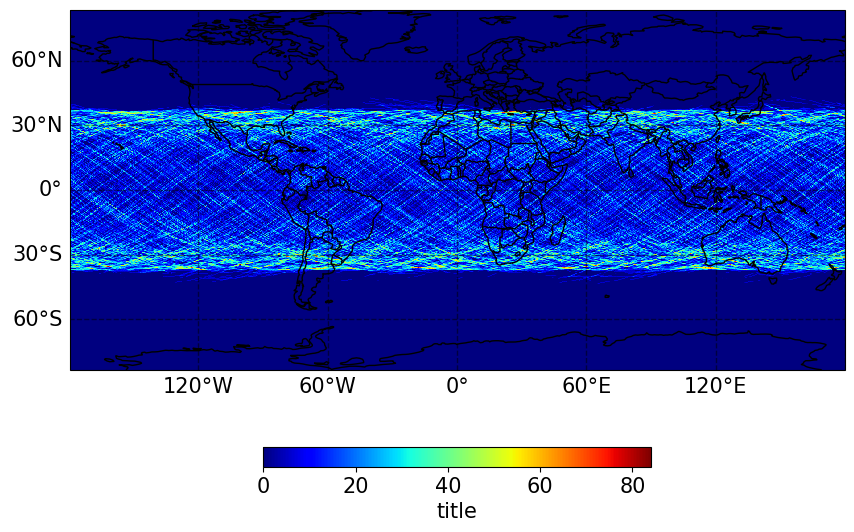

(<Figure size 1000x1000 with 2 Axes>, <GeoAxes: >)

In [44]:
hPlot.plot_map(ref_lon, ref_lat, data_count, 'title', 0, np.nanmax(data_count), cmap='jet', bounds=None, dem_path=None)

In [ ]:
plt.figure(figsize=(10, 6))
variance = (angle_sum_sq / data_count) - (angle_sum / data_count) ** 2
std_deviation = np.sqrt(variance)
#im = plt.imshow(angle_sum/data_count, cmap='viridis')
#im = plt.imshow((angle_sum_sq/data_count) - (angle_sum / data_count)**2, cmap='viridis')
im = plt.imshow(std_deviation, cmap='viridis')
plt.colorbar(im)
plt.title("Visualization")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()

In [85]:
import pandas as pd
resol = "36km"
csv_file     = hData.get_file_list('/Users/hyunglokkim/cpuserver_data/CYGNSS/data_counts_csv', 'csv', filter_strs=["data_count_"+resol+".csv"])
data_counts  = pd.read_csv(csv_file[0], header=None).values
csv_file     = hData.get_file_list('/Users/hyunglokkim/cpuserver_data/CYGNSS/data_counts_csv', 'csv', filter_strs=["angle_sum_"+resol+".csv"])
angle_sum    = pd.read_csv(csv_file[0], header=None).values
csv_file     = hData.get_file_list('/Users/hyunglokkim/cpuserver_data/CYGNSS/data_counts_csv', 'csv', filter_strs=["angle_sum_sq_"+resol+".csv"])
angle_sum_sq = pd.read_csv(csv_file[0], header=None).values

In [47]:
lon, lat = hGrid.generate_lon_lat_e2grid(resol)

Processing row 0/406
Processing row 100/406
Processing row 200/406
Processing row 300/406
Processing row 400/406


In [48]:
#modis_LULC = hLULC.
FP = cpuserver_data_FP + '/LULC/MCD12C1/'
file_list =  hData.get_file_list(FP, 'hdf')
input_file = file_list[0]
MCD12C1_t1 = hData.read_hdf4_variable(input_file, 'Majority_Land_Cover_Type_1')

In [49]:
lon_eqd_5km, lat_eqd_5km = hGrid.generate_lon_lat_eqdgrid(0.05)
LULC = hData.Resampling(lat, lon, lat_eqd_5km, lon_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=3)

In [50]:
lon_eqd_5km.shape, MCD12C1_t1.shape, LULC.shape, lat.shape

((3600, 7200), (3600, 7200), (406, 964), (406, 964))

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_61558/1760812641.py:4: RuntimeWarning: invalid value encountered in sqrt
  std = var**0.5


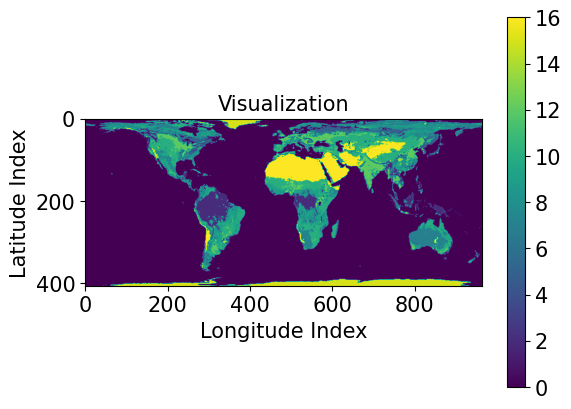

In [51]:
with np.errstate(divide='ignore', invalid='ignore'):
    var = angle_sum_sq/data_counts-(angle_sum / data_counts)**2
    var[data_counts == 0] = np.nan  # Explicitly set where denominator is zero to NaN
std = var**0.5
im=plt.imshow(LULC)
plt.colorbar(im)
plt.title("Visualization")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_61558/875844706.py:2: RuntimeWarning: invalid value encountered in divide
  inc = angle_sum / data_counts
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_61558/875844706.py:3: RuntimeWarning: invalid value encountered in divide
  std = (angle_sum_sq / data_counts - (angle_sum / data_counts)**2)**0.5
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_61558/875844706.py:3: RuntimeWarning: invalid value encountered in sqrt
  std = (angle_sum_sq / data_counts - (angle_sum / data_counts)**2)**0.5


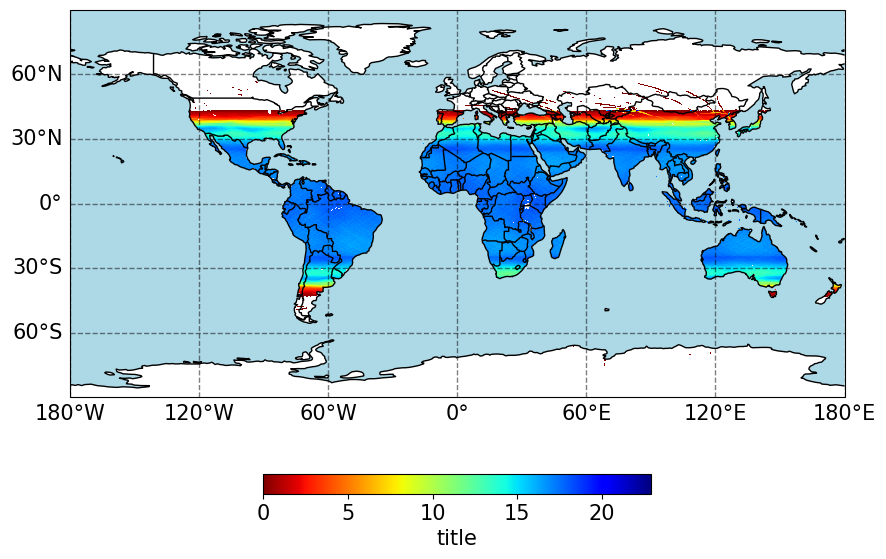

(<Figure size 1000x1000 with 2 Axes>, <GeoAxes: >)

In [102]:
#val = data_counts
inc = angle_sum / data_counts
std = (angle_sum_sq / data_counts - (angle_sum / data_counts)**2)**0.5
val = data_counts.copy()
val = std
val[LULC == 0] = np.nan
#val[inc>45] = np.nan
hPlot.plot_map(lon, lat, val, 'title', 0, np.nanmax(val), cmap='jet_r', bounds=[-180,180, -90, 90], dem_path=None)

In [ ]:
LULC.shape, lat.shape
plt.imshow(LULC)

In [ ]:
plt.imshow(val)

In [ ]:
plt.hist(val[:].flatten())